In [199]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "../data_sets/mimic-iii-data/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')           # Item descriptions
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')        # ICU stay times
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) # Chart 

         

In [225]:
# Filter for Acute Bronchitis (ICD-9 = 4660)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '4660'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)

df_target.head()

(126, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
1463,249,116935,4660
5865,494,125330,4660
8150,849,138670,4660
8918,739,172752,4660
12591,1063,183863,4660


In [227]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(126, 6)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE
0,249,116935,4660,2149-12-17 20:41:00,2149-12-31 14:55:00,EMERGENCY
1,494,125330,4660,2168-02-20 23:36:00,2168-03-02 16:15:00,EMERGENCY
2,849,138670,4660,2167-11-20 07:08:00,2167-11-25 15:19:00,EMERGENCY
3,739,172752,4660,2197-11-21 20:45:00,2197-12-11 03:16:00,EMERGENCY
4,1063,183863,4660,2119-10-18 18:16:00,2119-11-10 12:30:00,EMERGENCY


In [ ]:
# Calculate LOS in days
# df_merged['LOS'] = (pd.to_datetime(df_merged['DISCHTIME']) - pd.to_datetime(df_merged['ADMITTIME'])).dt.total_seconds() / 86400

# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_merged.isnull().sum()


(126, 2)


SUBJECT_ID        0
HADM_ID           0
ADMITTIME         0
DISCHTIME         0
ADMISSION_TYPE    0
ICUSTAY_ID        1
INTIME            1
OUTTIME           1
LOS               1
GENDER            0
DOB               0
dtype: int64

In [201]:
df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])

# Correctly subtract the years
df_merged['age'] = df_merged['ADMITTIME'].dt.year - df_merged['DOB'].dt.year
df_merged.loc[df_merged['age'] > 89, 'age'] = 91  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.drop(df_merged['LOS'].idxmax())

df_merged.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,EMERGENCY,215044.0,2149-12-18 20:06:02,2149-12-24 13:31:45,5.7262,F,2075-03-13,74
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00,EMERGENCY,224081.0,2168-02-21 05:00:22,2168-02-23 12:35:22,2.3160,F,2109-12-22,59
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00,EMERGENCY,284291.0,2167-11-20 07:10:00,2167-11-25 15:19:00,5.3396,M,2087-06-25,80
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00,EMERGENCY,299463.0,2197-11-22 16:27:00,2197-12-11 03:16:00,18.4507,F,2137-04-27,60
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00,EMERGENCY,231364.0,2119-10-18 18:17:53,2119-11-10 12:30:22,22.7587,F,2050-01-27,69


In [202]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())

Top 5 Shortest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS               INTIME  \
79        23706   152199    288697.0  1.0404  2199-06-06 11:45:16   
129       69225   171381    260607.0  1.0776  2149-05-11 15:27:17   
55        17767   173368    230180.0  1.1000  2115-08-29 16:12:00   
45        13855   125990    292531.0  1.1045  2135-07-02 22:24:04   
30         7934   101013    247900.0  1.1109  2182-02-05 14:01:42   

                 OUTTIME  age  
79   2199-06-07 12:43:26   65  
129  2149-05-12 17:19:05   81  
55   2115-08-30 18:36:00   46  
45   2135-07-04 00:54:37   58  
30   2182-02-06 16:41:27   91  


In [203]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())


Top 5 Longest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  age
6          1692   120536    284245.0  40.1410   74
116       55672   126629    295677.0  37.8437   58
75        21857   151278    246121.0  27.8042   74
48        13050   181699    285873.0  27.6797   69
71        20190   119413    200375.0  26.5294   53


In [204]:
df_merged.shape

(123, 12)

In [205]:
# df_chart_events =  pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)        
# 
# df_chart_events.head()

In [206]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,123.0,26249.804878,249.0,10289.5,21572.0,28923.5,93187.0,22456.180196
HADM_ID,123.0,151379.333333,100338.0,125660.0,152199.0,178417.5,199976.0,29683.259951
ADMITTIME,123,2146-05-05 03:45:41.463415808,2101-12-21 18:56:00,2119-09-16 07:04:30,2145-01-22 22:53:00,2170-06-21 14:38:30,2202-09-10 16:58:00,NaN
ICUSTAY_ID,123.0,251503.691057,200249.0,223766.0,253861.0,279511.5,299463.0,29955.276234
LOS,123.0,6.54642,1.0404,2.03595,3.6504,6.8717,40.141,7.606687
DOB,123,2062-07-25 01:21:57.073170944,1806-08-18 00:00:00,2049-01-07 12:00:00,2077-08-29 00:00:00,2101-11-06 00:00:00,2172-08-20 00:00:00,NaN
age,123.0,65.065041,25.0,53.0,65.0,76.5,91.0,15.935701


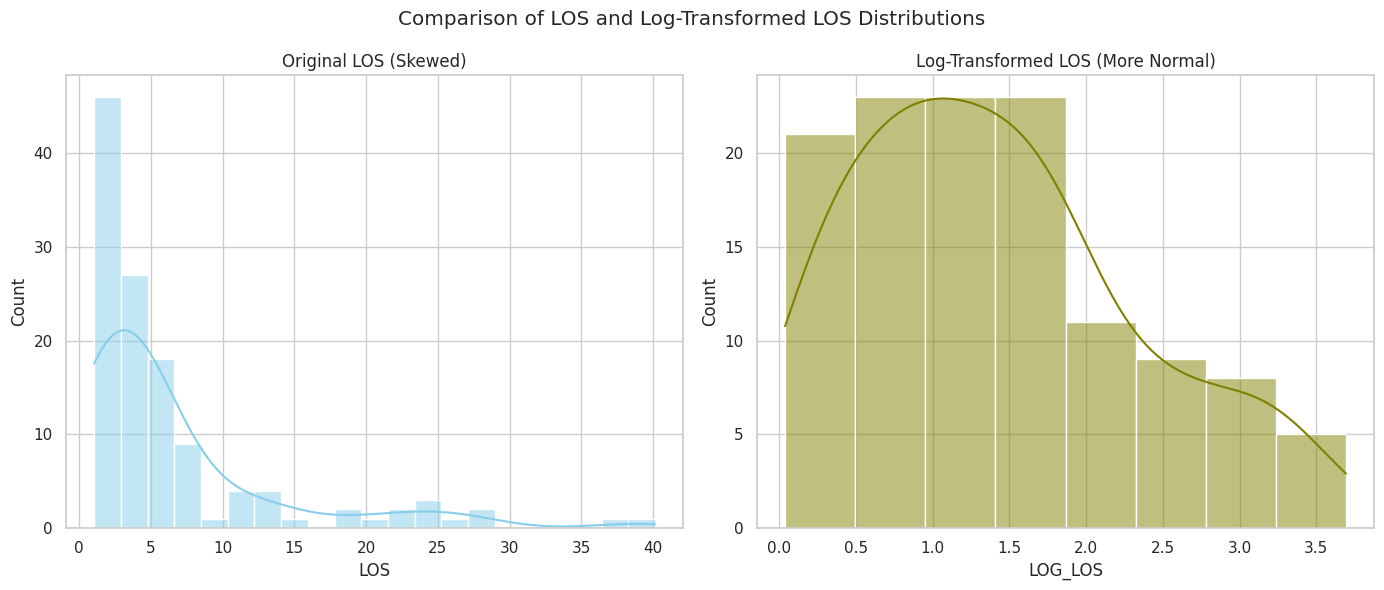

In [207]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [208]:
selected_small_id = 220271
selected_mean_id =  284345
selected_big_id = 200375

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22486,25628,20190,119413,200375,carevue,CCU,CSRU,57,14,2138-10-15 23:22:54,2138-11-11 12:05:15,26.5294


In [209]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime


(Timestamp('2138-10-15 23:22:54'), Timestamp('2138-10-16 23:22:54'))

In [210]:
# df_chart_events[df_chart_events['ICUSTAY_ID'] == selected_mean_id ]

# df_24h = df_chart_events[
#     (df_chart_events['ICUSTAY_ID'] == selected_big_id)
    
# ]
# df_24h.head()

# df_chart_events.head()

In [211]:
print(df_merged.shape)
df_merged.head()

(123, 13)


,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age,LOG_LOS
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,EMERGENCY,215044.0,2149-12-18 20:06:02,2149-12-24 13:31:45,5.7262,F,2075-03-13,74,1.745052
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00,EMERGENCY,224081.0,2168-02-21 05:00:22,2168-02-23 12:35:22,2.3160,F,2109-12-22,59,0.839842
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00,EMERGENCY,284291.0,2167-11-20 07:10:00,2167-11-25 15:19:00,5.3396,M,2087-06-25,80,1.675151
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00,EMERGENCY,299463.0,2197-11-22 16:27:00,2197-12-11 03:16:00,18.4507,F,2137-04-27,60,2.915102
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00,EMERGENCY,231364.0,2119-10-18 18:17:53,2119-11-10 12:30:22,22.7587,F,2050-01-27,69,3.124947


In [217]:
df_chart_events =  pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)  
print(df_chart_events.shape)      
df_chart_events.head()
# df_merged = pd.merge(df_merged, df_chart_events, how='inner')

# df_merged

(54437, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,354565,4113,103203,258274,220051,2149-10-09 23:00:00,2149-10-09 23:10:00,15023,83.0,83.0,mmHg,0.0,0.0,NaN,NaN
1,354566,4113,103203,258274,220052,2149-10-09 23:00:00,2149-10-09 23:10:00,15023,118.0,118.0,mmHg,0.0,0.0,NaN,NaN
2,354567,4113,103203,258274,220210,2149-10-09 23:00:00,2149-10-09 23:10:00,15023,18.0,18.0,insp/min,0.0,0.0,NaN,NaN
3,354568,4113,103203,258274,220277,2149-10-09 23:00:00,2149-10-09 23:10:00,15023,100.0,100.0,%,0.0,0.0,NaN,NaN
4,354569,4113,103203,258274,220292,2149-10-09 23:00:00,2149-10-09 23:34:00,14211,4.0,4.0,L/min,0.0,0.0,NaN,NaN


In [222]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']],  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)

print(df_merged.shape)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

(123, 13)
ICU stays WITH CHARTEVENTS data: 42
ICU stays WITHOUT CHARTEVENTS data: 81


In [214]:
icu_with_data

array([215044., 224081., 284291., 299463., 246908., 258274., 251730.,
       292338., 212147., 216000., 254085., 287899., 289153., 295731.,
       261745., 275486., 278183., 200439., 265286., 211605., 201794.,
       262596., 295677., 255865., 234270., 204024., 281556., 237101.,
       241546., 213641., 293173., 276541., 248848., 205602., 269883.,
       260607., 250285., 205745., 269907., 210342., 238500., 277431.])

In [215]:
df_merged

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age,LOG_LOS
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,EMERGENCY,215044.0,2149-12-18 20:06:02,2149-12-24 13:31:45,5.7262,F,2075-03-13,74,1.745052
1,494,125330,2168-02-20 23:36:00,2168-03-02 16:15:00,EMERGENCY,224081.0,2168-02-21 05:00:22,2168-02-23 12:35:22,2.3160,F,2109-12-22,59,0.839842
2,849,138670,2167-11-20 07:08:00,2167-11-25 15:19:00,EMERGENCY,284291.0,2167-11-20 07:10:00,2167-11-25 15:19:00,5.3396,M,2087-06-25,80,1.675151
3,739,172752,2197-11-21 20:45:00,2197-12-11 03:16:00,EMERGENCY,299463.0,2197-11-22 16:27:00,2197-12-11 03:16:00,18.4507,F,2137-04-27,60,2.915102
4,1063,183863,2119-10-18 18:16:00,2119-11-10 12:30:00,EMERGENCY,231364.0,2119-10-18 18:17:53,2119-11-10 12:30:22,22.7587,F,2050-01-27,69,3.124947
...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,78101,177078,2192-10-01 19:18:00,2192-12-24 14:33:00,EMERGENCY,205745.0,2192-10-01 19:18:33,2192-10-25 23:31:30,24.1757,M,2123-03-25,69,3.185348
134,82575,197823,2178-01-06 06:46:00,2178-02-03 23:59:00,EMERGENCY,269907.0,2178-01-06 06:50:49,2178-01-13 01:14:09,6.7662,M,2121-12-28,57,1.911940
135,91199,108165,2198-12-10 18:32:00,2198-12-21 12:30:00,EMERGENCY,210342.0,2198-12-15 23:40:19,2198-12-18 21:48:41,2.9225,M,2145-11-11,53,1.072439
136,93187,121896,2120-01-09 01:54:00,2120-02-01 16:15:00,EMERGENCY,238500.0,2120-01-09 01:55:33,2120-01-10 21:56:15,1.8338,M,2049-02-09,71,0.606390


In [220]:
df_merged[df_merged['ICUSTAY_ID'] == 215044]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age,LOG_LOS
0,249,116935,2149-12-17 20:41:00,2149-12-31 14:55:00,EMERGENCY,215044.0,2149-12-18 20:06:02,2149-12-24 13:31:45,5.7262,F,2075-03-13,74,1.745052
